# Compare two GEOS-Chem Classic datasets

## Overview of this Notebook

* Import dependencies
* Define functions: utility, grid, and plotting
* Define data directories and global variables
* Compare restart files
* Store areas for normalization
* Compare SpeciesConc diagnostic collection
* Create PDFs for subset of species
* Other diagnostic collections

## Import dependencies

In [1]:
import os
import numpy as np
import xarray as xr
import cubedsphere as cs
import xesmf as xe
import xbpch
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from cartopy import crs
from cartopy.mpl.geoaxes import GeoAxes
import gcpy as gc

# Enable auto-reloading modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
import warnings; warnings.filterwarnings("ignore")

## Define grid functions

In [2]:
def make_grid_LL(llres):
    [dlat,dlon] = list(map(float, llres.split('x')))
    lon_b = np.linspace(-180 - dlon/2, 180 - dlon/2, int(360/dlon) + 1, endpoint=True)
    lat_b = np.linspace(-90 - dlat/2, 90 + dlat/2, int(180/dlat) + 2, endpoint=True).clip(-90,90)
    lat = (lat_b[1:] + lat_b[:-1]) / 2
    lon = (lon_b[1:] + lon_b[:-1]) / 2
    llgrid = {'lat': lat, 
              'lon': lon, 
              'lat_b': lat_b, 
              'lon_b': lon_b}
    return llgrid

## Define functions for plotting

### Function to plot and compare single vertical level of GC Classic

Notes: The two GCX files must be at the same grid resolution. You can use this function to plot interactively or to generate a multi-page pdf of plots. It takes a list of variable names to plot for a single collection only. You can plot for any level and any time slice in the file. By default the colorbars for the plots will have the same range, but you can turn this feature off. Also by default the colorbar of the fractional difference between the model outputs will be limited to +/-2, but you can change this as well via the passed parameters.

In [3]:
def compare_single_level(refdata, refstr, devdata, devstr, llres, varlist=None, ilev=0, itime=0, savepdf=False, 
                         pdfname='map.pdf', match_cbar=True, normalize_by_area=False, check_units=True):
    
    # If no varlist is passed, plot all (surface only for 3D)
    if varlist == None:
        [varlist, commonvars2D, commonvars3D] = compare_varnames(refdata, devdata)
        print('Plotting all common variables (surface only if 3D)')
    n_var = len(varlist)

    # Get lat-lon grid
    llgrid = make_grid_LL(llres)

    # Get lat/lon extents
    [minlon, maxlon] = [min(llgrid['lon_b']), max(llgrid['lon_b'])]
    [minlat, maxlat] = [min(llgrid['lat_b']), max(llgrid['lat_b'])]
    
    # Create pdf (if saving)
    if savepdf:
        print('\nCreating {} for {} variables'.format(pdfname,n_var))
        pdf = PdfPages(pdfname)

    # Loop over variables
    for ivar in range(n_var):
        if savepdf: print('{} '.format(ivar), end='')
        varname = varlist[ivar]
        
        # Do some checks: dimensions and units
        varndim_ref = refdata[varname].ndim
        varndim_dev = devdata[varname].ndim
        if check_units: 
            assert varndim_ref == varndim_dev, 'Dimensions do not agree for {}!'.format(varname)
        units_ref = refdata[varname].units
        units_dev = devdata[varname].units
        if check_units: 
            assert units_ref == units_dev, 'Units do not match for {}!'.format(varname)
            
        # if normalizing by area, adjust units to be per m2, and adjust title string
        units = units_ref
        varndim = varndim_ref
        subtitle_extra = ''
                    
        # Slice the data
        if varndim == 4: 
            ds_ref = refdata[varname].isel(time=itime,lev=ilev)
            ds_dev = devdata[varname].isel(time=itime,lev=ilev)
        elif varndim == 3: 
            ds_ref = refdata[varname].isel(time=itime)
            ds_dev = devdata[varname].isel(time=itime)
            
        # if normalizing by area, transform on the native grid and adjust units and subtitle string
        exclude_list = ['WetLossConvFrac','Prod_','Loss_']
        if normalize_by_area and not any(s in varname for s in exclude_list):
            ds_ref.values = ds_ref.values / refdata['AREAM2'].values
            ds_dev.values = ds_dev.values / devdata['AREAM2'].values
            units = '{} m-2'.format(units)
            subtitle_extra = ', Normalized by Area'
            
        # Regrid the slices (skip for gchp vs gchp for now)
        vmin_ref = ds_ref.min()
        vmin_dev = ds_dev.min()
        vmin_cmn = np.min([vmin_ref, vmin_dev])
        vmax_ref = ds_ref.max()
        vmax_dev = ds_dev.max()
        vmax_cmn = np.max([vmax_ref, vmax_dev])
        if match_cbar: [vmin, vmax] = [vmin_cmn, vmax_cmn]
        
        # Create 2x2 figure
        figs, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, figsize=[12,14], 
                                                      subplot_kw={'projection': crs.PlateCarree()})
        # Give the figure a title
        offset = 0.96
        fontsize=25
        if varndim == 4:
            if ilev == 0: levstr = 'Surface'
            elif ilev == 22: levstr = '500 hPa'
            else: levstr = 'Level ' +  str(ilev-1)
            figs.suptitle('{}, {}'.format(varname,levstr), fontsize=fontsize, y=offset)
        elif varndim == 3: 
            figs.suptitle('{}'.format(varname), fontsize=fontsize, y=offset)
        else:
            print('varndim is 2 for {}! Must be 3 or 4.'.format(varname))   
        
        # Subplot (0,0): Ref
        ax0.coastlines()
        if not match_cbar: [vmin, vmax] = [vmin_ref, vmax_ref]
        plot0 = ax0.imshow(ds_ref, extent=(minlon, maxlon, minlat, maxlat), 
                           cmap=gc.plot.WhGrYlRd,vmin=vmin, vmax=vmax)
        ax0.set_title('{} (Ref){}\n{}'.format(refstr,subtitle_extra,llres)) 
        cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot (0,1): Dev
        ax1.coastlines()
        if not match_cbar: [vmin, vmax] = [vmin_dev, vmax_dev]
        plot1 = ax1.imshow(ds_dev, extent=(minlon, maxlon, minlat, maxlat), 
                           cmap=gc.plot.WhGrYlRd,vmin=vmin, vmax=vmax)
        ax1.set_title('{} (Dev){}\n{}'.format(devstr,subtitle_extra,llres)) 
        cb = plt.colorbar(plot1, ax=ax1, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
            
        # Calculate difference
        absdiff = ds_dev - ds_ref
            
        # Subplot (1,0): Difference, full dynamic range
        diffabsmax = max([np.abs(absdiff.min()), np.abs(absdiff.max())])
        [vmin, vmax] = [-diffabsmax, diffabsmax]
        ax2.coastlines()
        plot2 = ax2.imshow(absdiff, extent=(minlon, maxlon, minlat, maxlat), 
                           cmap='RdBu_r',vmin=vmin, vmax=vmax)
        ax2.set_title('Difference\nDev - Ref, Dynamic Range') 
        cb = plt.colorbar(plot2, ax=ax2, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot (1,1): Difference, restricted range
        [vmin, vmax] = [-1e-9, 1e-9] # Placeholder; need a dictional for this (species: limit)
        ax3.coastlines()
        plot3 = ax3.imshow(absdiff, extent=(minlon, maxlon, minlat, maxlat), 
                           cmap='RdBu_r',vmin=vmin, vmax=vmax)
        ax3.set_title('Difference\nDev - Ref, Fixed Range') 
        cb = plt.colorbar(plot3, ax=ax3, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)

        # Calculate fractional difference
        fracdiff = (ds_dev - ds_ref) / ds_ref
        
        # Subplot (2,0): Fractional Difference, full dynamic range
        fracdiffabsmax = max([np.abs(fracdiff.min()), np.abs(fracdiff.max())])
        [vmin, vmax] = [-fracdiffabsmax, fracdiffabsmax]
        ax4.coastlines()
        plot4 = ax4.imshow(fracdiff, extent=(minlon, maxlon, minlat, maxlat), 
                           cmap='RdBu_r',vmin=vmin, vmax=vmax)
        ax4.set_title('Fractional Difference\n(Dev-Ref)/Ref, Dynamic Range') 
        cb = plt.colorbar(plot4, ax=ax4, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)  
        
        # Subplot (2,1): Fractional Difference, restricted
        [vmin, vmax] = [-2, 2]
        #[vmin, vmax] = [-0.5, 2] # doesn't work with this colorbar. Need to customize one. Already in gamap?
                                  # Switch to this if change to ratios (dev/ref)
        ax5.coastlines()
        plot5 = ax5.imshow(fracdiff, extent=(minlon, maxlon, minlat, maxlat), 
                           cmap='RdBu_r',vmin=vmin, vmax=vmax)
        ax5.set_title('Fractional Difference\n(Dev-Ref)/Ref, Fixed Range') 
        cb = plt.colorbar(plot5, ax=ax5, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)  
            
        if savepdf:    
            pdf.savefig(figs)
            plt.close(figs)
            
    if savepdf: pdf.close()

### Function to plot and compare zonal mean

Many of the same features available for plotting a single level above are also available for this function.

In [4]:
def compare_zonal_mean(refdata, refstr, devdata, devstr, llres, varlist=None, itime=0, savepdf=False, 
                       pdfname='zonalmean.pdf', match_cbar=True, normalize_by_area=False, check_units=True ):

    # If no varlist is passed, plot all 3D variables in the dataset
    if varlist == None:
        [commonvars, commonvars2D, varlist] = compare_varnames(refdata, devdata)
        print('Plotting all 3D variables')
    n_var = len(varlist)
    
    # Get lat-lon grid
    llgrid = make_grid_LL(llres)
    
    # Universal plot setup
    xtick_positions = np.arange(-90,91,30)
    xticklabels = ['{}$\degree$'.format(x) for x in xtick_positions]
    ytick_positions = np.arange(0,61,20)
    yticklabels = [str(y) for y in ytick_positions]
    
    # Create pdf (if saving)
    if savepdf:
        print('\nCreating {} for {} variables'.format(pdfname, n_var))
        pdf = PdfPages(pdfname)

    # Loop over variables
    for ivar in range(n_var):
        if savepdf: print('{} '.format(ivar), end='')
        varname = varlist[ivar]
        
        # Do some checks: dimensions and units
        varndim_ref = refdata[varname].ndim
        varndim_dev = devdata[varname].ndim
        nlev = 72
        assert varndim_ref == varndim_dev, 'Dimensions do not agree for {}!'.format(varname)
        units_ref = refdata[varname].units
        units_dev = devdata[varname].units
        assert units_ref == units_dev, 'Units do not match for {}!'.format(varname)
        
        # Set plot extent
        extent=(-90,90,0,nlev)
        
        # if normalizing by area, adjust units to be per m2, and adjust title string
        units = units_ref
        varndim = varndim_ref
        subtitle_extra = ''
        
        # Slice the data
        ds_ref = refdata[varname].isel(time=itime)
        ds_dev = devdata[varname].isel(time=itime)

        # if normalizing by area, transform on the native grid and adjust units and subtitle string
        exclude_list = ['WetLossConvFrac','Prod_','Loss_']
        if normalize_by_area and not any(s in varname for s in exclude_list):
            ds_ref.values = ds_ref.values / refdata['AREAM2'].values[np.newaxis,:,:]
            ds_dev.values = ds_dev.values / devdata['AREAM2'].values[np.newaxis,:,:]
            units = '{} m-2'.format(units)
            subtitle_extra = ', Normalized by Area'
            
        # Calculate zonal mean of the regridded data
        zm_ref = ds_ref.mean(axis=2)
        zm_dev = ds_dev.mean(axis=2)
            
        # Get min and max for colorbar limits
        [vmin_ref, vmax_ref] = [zm_ref.min(), zm_ref.max()]
        [vmin_dev, vmax_dev] = [zm_dev.min(), zm_dev.max()]
        vmin_cmn = np.min([vmin_ref, vmin_dev])
        vmax_cmn = np.max([vmax_ref, vmax_dev])
        if match_cbar: [vmin, vmax] = [vmin_cmn, vmax_cmn]
        
        # Create 2x2 figure
        figs, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, figsize=[12,15.3], 
                                                      subplot_kw={'projection': crs.PlateCarree()})
        # Give the page a title
        offset = 0.96
        fontsize=25
        figs.suptitle('{}, Zonal Mean'.format(varname), fontsize=fontsize, y=offset)

        # Subplot 0: Ref
        if not match_cbar: [vmin, vmax] = [vmin_ref, vmax_ref]
        plot0 = ax0.imshow(zm_ref, cmap=gc.plot.WhGrYlRd, extent=extent, vmin=vmin, vmax=vmax)
        ax0.set_title('{} (Ref){}\n{}'.format(refstr, subtitle_extra, llres ))
        ax0.set_aspect('auto')
        ax0.set_xticks(xtick_positions)
        ax0.set_xticklabels(xticklabels)
        ax0.set_yticks(ytick_positions)
        ax0.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot 1: Dev
        if not match_cbar: [vmin, vmax] = [vmin_dev, vmax_dev]
        plot1 = ax1.imshow(zm_dev, cmap=gc.plot.WhGrYlRd, extent=extent, vmin=vmin, vmax=vmax)
        ax1.set_title('{} (Dev){}\n{}'.format(devstr, subtitle_extra, llres))
        ax1.set_aspect('auto')
        ax1.set_xticks(xtick_positions)
        ax1.set_xticklabels(xticklabels)
        ax1.set_yticks(ytick_positions)
        ax1.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot1, ax=ax1, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Calculate zonal mean difference
        zm_diff = zm_dev - zm_ref
                
        # Subplot 2: Difference, dynamic range
        diffabsmax = max([np.abs(zm_diff.min()), np.abs(zm_diff.max())])
        [vmin, vmax] = [-diffabsmax, diffabsmax]
        plot2 = ax2.imshow(zm_diff, cmap='RdBu_r', extent=extent, vmin=vmin, vmax=vmax)
        ax2.set_title('Difference\nDev - Ref, Dynamic Range')
        ax2.set_aspect('auto')
        ax2.set_xticks(xtick_positions)
        ax2.set_xticklabels(xticklabels)
        ax2.set_yticks(ytick_positions)
        ax2.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot2, ax=ax2, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot 3: Difference, restricted range
        [vmin, vmax] = [-1e-9, 1e-9] # need a dictional for this (species: limit)
        plot3 = ax3.imshow(zm_diff, cmap='RdBu_r', extent=extent, vmin=vmin, vmax=vmax)
        ax3.set_title('Difference\nDev - Ref, Fixed Range')
        ax3.set_aspect('auto')
        ax3.set_xticks(xtick_positions)
        ax3.set_xticklabels(xticklabels)
        ax3.set_yticks(ytick_positions)
        ax3.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot3, ax=ax3, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Zonal mean fractional difference
        zm_fracdiff = (zm_dev - zm_ref) / zm_ref
            
        # Subplot 4: Fractional Difference, dynamic range
        fracdiffabsmax = max([np.abs(zm_fracdiff.min()), np.abs(zm_fracdiff.max())])
        [vmin, vmax] = [-fracdiffabsmax, fracdiffabsmax]
        plot4 = ax4.imshow(zm_fracdiff, vmin=vmin, vmax=vmax, cmap='RdBu_r', extent=extent)
        ax4.set_title('Fractional Difference\n(Dev-Ref)/Ref, Dynamic Range')
        ax4.set_aspect('auto')
        ax4.set_xticks(xtick_positions)
        ax4.set_xticklabels(xticklabels)
        ax4.set_yticks(ytick_positions)
        ax4.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot4, ax=ax4, orientation='horizontal', pad=0.10)
        cb.set_clim(vmin=vmin, vmax=vmax)
        cb.set_label('unitless')   
        
        # Subplot 5: Fractional Difference, restricted range
        [vmin, vmax] = [-2, 2]
        plot5 = ax5.imshow(zm_fracdiff, vmin=vmin, vmax=vmax, cmap='RdBu_r', extent=extent)
        ax5.set_title('Fractional Difference\n(Dev-Ref)/Ref, Fixed Range')
        ax5.set_aspect('auto')
        ax5.set_xticks(xtick_positions)
        ax5.set_xticklabels(xticklabels)
        ax5.set_yticks(ytick_positions)
        ax5.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot5, ax=ax5, orientation='horizontal', pad=0.10)
        cb.set_clim(vmin=vmin, vmax=vmax)
        cb.set_label('unitless') 
            
        if savepdf:    
            pdf.savefig(figs)
            plt.close(figs)
            
    if savepdf: pdf.close()

## Define directories and global information

In [6]:
# Shared high-level directory
testdir = '/Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test'

# Ref and dev run output directories
refdir = os.path.join(testdir,'12.0.3_nc')
devdir = os.path.join(testdir,'12.1.0_nc')

# Ref and dev strings (for use in plots and messages)
refstr='12.0.3'
devstr='12.1.0'

# Set directory to store plots
plotsdir = os.path.join(testdir,'plots')

# Define cubed sphere resolutions (used for restart file comparison)
llres = '4x5'

# Check that paths exist
gc.core.check_paths(refdir, devdir)

Path 1 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/12.0.3_nc
Path 2 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/12.1.0_nc


### Print Ref netcdf filenames

In [7]:
reffiles = [k for k in os.listdir(refdir) if '.nc' in k]
for k in reffiles:
    print(k)

GEOSChem.AerosolMass.20160701_0000z.nc4
GEOSChem.Aerosols.20160701_0000z.nc4
GEOSChem.CloudConvFlux.20160701_0000z.nc4
GEOSChem.ConcAfterChem.20160701_0000z.nc4
GEOSChem.DryDep.20160701_0000z.nc4
GEOSChem.JValues.20160701_0000z.nc4
GEOSChem.JValuesLocalNoon.20160701_0000z.nc4
GEOSChem.LevelEdgeDiags.20160701_0000z.nc4
GEOSChem.ProdLoss.20160701_0000z.nc4
GEOSChem.SpeciesConc.20160701_0000z.nc4
GEOSChem.StateChm.20160701_0000z.nc4
GEOSChem.StateMet.20160701_0000z.nc4
GEOSChem.WetLossConv.20160701_0000z.nc4
GEOSChem.WetLossLS.20160701_0000z.nc4
HEMCO_diagnostics.201607010000.nc


### Print Dev netcdf filenames

In [8]:
devfiles = [k for k in os.listdir(devdir) if '.nc' in k]
for k in devfiles:
    print(k)

GEOSChem.AerosolMass.20160701_0000z.nc4
GEOSChem.Aerosols.20160701_0000z.nc4
GEOSChem.Budget.20160701_0000z.nc4
GEOSChem.CloudConvFlux.20160701_0000z.nc4
GEOSChem.ConcAfterChem.20160701_0000z.nc4
GEOSChem.DryDep.20160701_0000z.nc4
GEOSChem.JValues.20160701_0000z.nc4
GEOSChem.JValuesLocalNoon.20160701_0000z.nc4
GEOSChem.LevelEdgeDiags.20160701_0000z.nc4
GEOSChem.ProdLoss.20160701_0000z.nc4
GEOSChem.SpeciesConc.20160701_0000z.nc4
GEOSChem.StateChm.20160701_0000z.nc4
GEOSChem.StateMet.20160701_0000z.nc4
GEOSChem.WetLossConv.20160701_0000z.nc4
GEOSChem.WetLossLS.20160701_0000z.nc4
HEMCO_diagnostics.201607010000.nc


## Compare Restart Files

In [9]:
#reffile_rst = os.path.join(refdir,'GEOSChem_restart.201607010000.nc')
#devfile_rst = os.path.join(devdir,'GEOSChem_restart.201607010000.nc')
#gc.core.check_paths(reffile_rst, devfile_rst)

In [10]:
#refdata_rst = xr.open_dataset(reffile_rst)
#devdata_rst = xr.open_dataset(devfile_rst)
#[commonvars, commonvars2D, commonvars3D] = gc.core.compare_varnames(refdata_rst, refstr, devdata_rst, devstr)

In [11]:
#gc.core.get_stats(refdata_rst, refstr, devdata_rst, devstr, 'SPC_CFC11')

In [12]:
#compare_zonal_mean( refdata_rst, refstr, devdata_rst, devstr, llres, varlist=['SPC_O3'] )

In [13]:
#compare_single_level( refdata_rst, refstr, devdata_rst, devstr, llres, varlist=['SPC_O3'] )

## Inspect time-averaged species concentration diagnostic

In [14]:
day = '20160701'
time = '0000'
collection = 'SpeciesConc'
[refdata, devdata] = gc.core.get_collection_data(refdir, devdir, collection, day, time)

Path 1 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/12.0.3_nc/GEOSChem.SpeciesConc.20160701_0000z.nc4
Path 2 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/12.1.0_nc/GEOSChem.SpeciesConc.20160701_0000z.nc4


In [15]:
[commonvars, commonvars2D, commonvars3D] = gc.core.compare_varnames(refdata, refstr, devdata, devstr)

189 common variables (0 are 2-dim and 183 are 3-dim)


In [16]:
CFCs=[k for k in commonvars if 'CFC' in k]
print(CFCs)

['SpeciesConc_CFC11', 'SpeciesConc_CFC113', 'SpeciesConc_CFC114', 'SpeciesConc_CFC115', 'SpeciesConc_CFC12', 'SpeciesConc_HCFC123', 'SpeciesConc_HCFC141b', 'SpeciesConc_HCFC142b', 'SpeciesConc_HCFC22']


In [17]:
varname='SpeciesConc_O3'
gc.core.compare_stats(refdata, refstr, devdata, devstr, varname)

Data units: mol mol-1 dry
Array sizes:
    12.0.3:  (1, 72, 46, 72)
    12.1.0:  (1, 72, 46, 72)
Global stats:
  Mean:
    12.0.3:  1.6954156762949424e-06
    12.1.0:  1.6924627743719611e-06
  Min:
    12.0.3:  3.0810258788704914e-09
    12.1.0:  3.0790432425931158e-09
  Max:
    12.0.3:  9.85150381893618e-06
    12.1.0:  9.842061444942374e-06
  Sum:
    12.0.3:  0.4042956233024597
    12.1.0:  0.40359145402908325


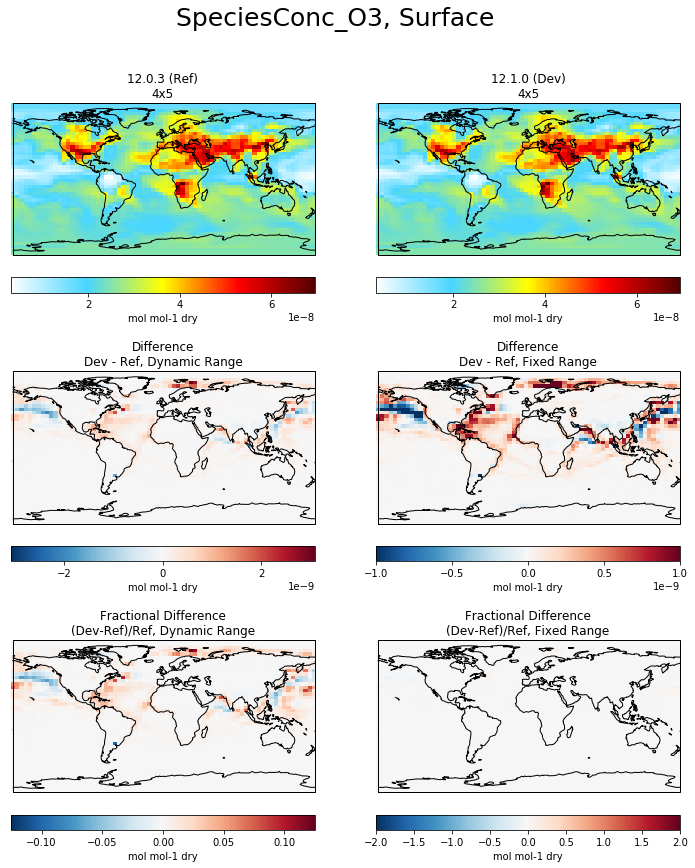

In [18]:
compare_single_level( refdata, refstr, devdata, devstr, llres, varlist=[varname] )

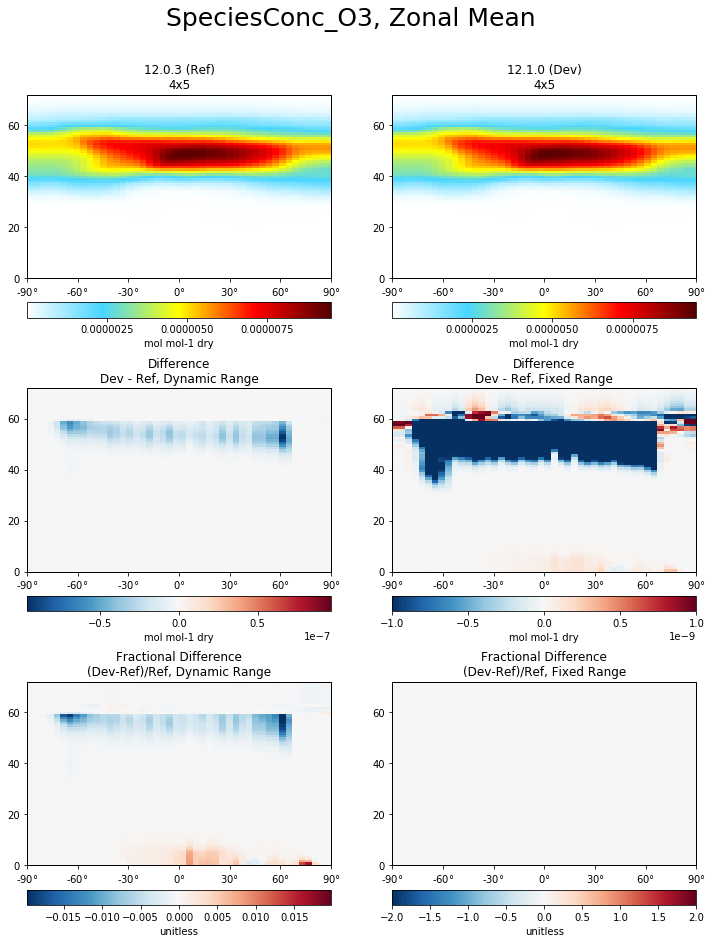

In [19]:
compare_zonal_mean( refdata, refstr, devdata, devstr, llres, varlist=[varname] )

## Create PDF of plots for list of species

In [20]:
# Define subset of variables in files
#varlist = commonvars3D
varlist = [varname]
#varlist = [k for k in commonvars3D if 'CFC' in k]

In [21]:
# Surface
#pdfname = os.path.join(plotsdir,'{}_Surface.pdf'.format(ref_collection))
pdfname = os.path.join(plotsdir,'{}_Surface.pdf'.format(varname))
#pdfname = os.path.join(plotsdir,'{}_Surface.pdf'.format('CFCs'))
compare_single_level( refdata, refstr, devdata, devstr, llres, varlist=varlist, ilev=0,
                     savepdf=True, pdfname=pdfname )


Creating /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/plots/SpeciesConc_O3_Surface.pdf for 1 variables
0 

In [22]:
# Zonal mean
#pdfname = os.path.join(plotsdir,'{}_ZonalMean.pdf'.format(ref_collection))
pdfname = os.path.join(plotsdir,'{}_ZonalMean.pdf'.format(varname))
#pdfname = os.path.join(plotsdir,'{}_ZonalMean.pdf'.format('CFCs'))
compare_zonal_mean(refdata, refstr, devdata, devstr, llres, varlist=varlist, 
                   savepdf=True, pdfname=pdfname )


Creating /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/plots/SpeciesConc_O3_ZonalMean.pdf for 1 variables
0 

## Other diagnostic collections

In [23]:
# Inspect the available files again, but only show those that match
commonfiles = [k for k in reffiles if k in devfiles]
commonfiles

['GEOSChem.AerosolMass.20160701_0000z.nc4',
 'GEOSChem.Aerosols.20160701_0000z.nc4',
 'GEOSChem.CloudConvFlux.20160701_0000z.nc4',
 'GEOSChem.ConcAfterChem.20160701_0000z.nc4',
 'GEOSChem.DryDep.20160701_0000z.nc4',
 'GEOSChem.JValues.20160701_0000z.nc4',
 'GEOSChem.JValuesLocalNoon.20160701_0000z.nc4',
 'GEOSChem.LevelEdgeDiags.20160701_0000z.nc4',
 'GEOSChem.ProdLoss.20160701_0000z.nc4',
 'GEOSChem.SpeciesConc.20160701_0000z.nc4',
 'GEOSChem.StateChm.20160701_0000z.nc4',
 'GEOSChem.StateMet.20160701_0000z.nc4',
 'GEOSChem.WetLossConv.20160701_0000z.nc4',
 'GEOSChem.WetLossLS.20160701_0000z.nc4',
 'HEMCO_diagnostics.201607010000.nc']

In [24]:
# Template for inspecting any collection:

# To specify file:
#day = {edit}
#time = {edit}
#collection = {edit}

# For retrieving the data:
#[refdata, devdata] = gc.core.get_collection_data(refdir, devdir, collection, day, time)

# For inspecting interactively:
#refdata
#devdata
#[commonvars, commonvars2D, commonvars3D] = gc.core.compare_varnames(refdata, refstr, devdata, devstr)
# varname = {edit}
#gc.core.get_stats(refdata, refstr, devdata, devstr, varname)
# varlist = {edit}
#compare_single_level(refdata, refstr, devdata, devstr, llres, varlist=[varname] )
#compare_zonal_mean(refdata, refstr, devdata, devstr, llres, varlist=[varname] )

# For creating PDFs:
#prefix = {edit}
#pdfname = os.path.join(plotsdir,'{}_Surface.pdf'.format(prefix))
#compare_single_level(refdata, refstr, devdata, devstr, llres, varlist=varlist, ilev=0,
#                     savepdf=True, pdfname=pdfname )
#pdfname = os.path.join(plotsdir,'{}_ZonalMean.pdf'.format(prefix))
#compare_zonal_mean(refdata, refstr, devdata, devstr, varlist=varlist, llres, 
#                   savepdf=True, pdfname=pdfname )

# For other function options use shift-tab while hovering over the function name in a cell that calls it

## Create lists of species

Primary checks: O3, NOx (NO+NO2), CO, OH, AOD

Aerosols: SO4, NIT, NH4, DST1, DST2, DST3, DST3, OCPI, OCPO, BCPI, BCPO, SALC, SALA, SO2s, SOA,

Nitrogen: NO, NO2, NO3, N2O5, HNO2, HNO4, CH3O2NO2, HNO3, PAN, PPN, IPMN, N2O, NH4, NH3, NIT, 
NOx, NOy (gas), NOy (gas+aerosol), NHx

ROy: OH, HO2, RO2 (sum all peroxy), O(1D), H2O2, H, H2, H2O, O(3P)

Primary Organics
  HCs: CH4, C2H6, C2H4, C3H8, PRPE, ALK4, BENZ, TOL, XYLE, ISOP, Monoterpenes
  Others: GLYX, HCOOH, MAP, MBO, MOH, RCHO

Secondary Organics
  Ketone: ACET, MEK, MVK
  Aldehydes: ALD2, CH2O, HPALD
  Peroxides: CH3OOH, ISOPOOH
  Nitrates: ISOPN
  Epoxides: IEPOX
  Acids: ACTA
  Alcohols: MOH, EtOH 

Sulfur: SO2, DMS, OCS, SO4, SOx (SO2+SO4)

Iodine: I, I2, ICl, IBr, IO, HOI, HI, INO2, INO3, OIO, IxOy, AERI+ISALA+ISALC
CH3I, CH2I2, CH2ICl, CH2IBr, IOy (I+IO+OIO+x*IxOy), 
Iy (I+ 2*I2+ ICl+ IBr+ HOI+ HI+ INO2+ INO3+ OIO+ x*IxOy+AERI+ISALA+ISALC)

Bromine: Br, BrO, Br2, BrCl, HOBr, HBr, BrNO2, BrNO3, CH3Br, CH2Br2, CHBr3,
BrOx(Br+BrO), Bry(Br, BrO, Br2, BrCl, HOBr, HBr, BrNO2, BrNO3)

Chlorine: Cl, ClO, Cl2, HOCl, HCl, Cl2O2, ClOO, ClNO2, ClNO3, OClO,
CCl4, CH3Cl, CH2Cl2, CH3CCl3, SUM(CFC11, CFC12, CFC113, CFC114, CFC115),
SUM(H1211, H1302, H2402), SUM(HCFC123, HCFC141b, HCFC142b),
ClOx (Cl+ClO), Cly (Cl, ClO, 2*Cl2, HOCl, HCl, Cl2O2, ClOO, ClNO2, ClNO3, OClO)


In [25]:
# Print list of species in file
spcvars = [k for k in commonvars if 'SpeciesConc' in k]
print('{} species:'.format(len(spcvars)))
print([k.replace('SpeciesConc_','') for k in spcvars])

183 species:
['ACET', 'ACTA', 'AERI', 'ALD2', 'ALK4', 'ASOA1', 'ASOA2', 'ASOA3', 'ASOAN', 'ASOG1', 'ASOG2', 'ASOG3', 'BCPI', 'BCPO', 'BENZ', 'Br', 'Br2', 'BrCl', 'BrNO2', 'BrNO3', 'BrO', 'BrSALA', 'BrSALC', 'C2H6', 'C3H8', 'CCl4', 'CFC11', 'CFC113', 'CFC114', 'CFC115', 'CFC12', 'CH2Br2', 'CH2Cl2', 'CH2I2', 'CH2IBr', 'CH2ICl', 'CH2O', 'CH3Br', 'CH3CCl3', 'CH3Cl', 'CH3I', 'CH4', 'CHBr3', 'CHCl3', 'CO', 'Cl', 'Cl2', 'Cl2O2', 'ClNO2', 'ClNO3', 'ClO', 'ClOO', 'DHDN', 'DMS', 'DST1', 'DST2', 'DST3', 'DST4', 'EOH', 'ETHLN', 'GLYC', 'GLYX', 'H1211', 'H1301', 'H2402', 'H2O', 'H2O2', 'HAC', 'HBr', 'HC187', 'HCFC123', 'HCFC141b', 'HCFC142b', 'HCFC22', 'HCOOH', 'HCl', 'HI', 'HNO2', 'HNO3', 'HNO4', 'HOBr', 'HOCl', 'HOI', 'HONIT', 'HPALD', 'I', 'I2', 'I2O2', 'I2O3', 'I2O4', 'IBr', 'ICl', 'IEPOXA', 'IEPOXB', 'IEPOXD', 'IMAE', 'INDIOL', 'INO', 'IO', 'IONITA', 'IONO', 'IONO2', 'IPMN', 'ISALA', 'ISALC', 'ISN1', 'ISN1OA', 'ISN1OG', 'ISOA1', 'ISOA2', 'ISOA3', 'ISOG1', 'ISOG2', 'ISOG3', 'ISOP', 'ISOPNB', 'I

Need to add several aggregates to the SpeciesConc dataset:
 NOx
 NOy (gas)
 NOy (gas+aerosol)
 RO2
 SOx
 IOy
 Iy
 BrOx
 Bry
 sumCFCs (need name)
 sumHs (need name)
 sumHCFCs (need name)
 ClOx
 Cly

Then pass lists to the plotting functions

Need to see if (1) any species not in any lists, (2) any species in multiple listes, (3) any species in lists 
are not in the GC output or defined as sums of GC output

## Read in bpch diagnostics

In [31]:
datafile = 'trac_avg.geosfp_4x5_benchmark.201607010000'

refstr = '12.0.3_bpch'
devstr = '12.1.0_bpch'

refdir_bp = os.path.join(testdir,refstr)
devdir_bp = os.path.join(testdir,devstr)
reftracerinfo_file = os.path.join(testdir,refstr,'tracerinfo.dat') 
refdiaginfo_file = os.path.join(testdir,refstr,'diaginfo.dat')
devtracerinfo_file = os.path.join(testdir,devstr,'tracerinfo.dat') 
devdiaginfo_file = os.path.join(testdir,devstr,'diaginfo.dat')

refdata = os.path.join(refdir_bp, datafile)
devdata = os.path.join(devdir_bp, datafile)
print('Checking bpch data files')
gc.core.check_paths(refdata, devdata)

print('\nChecking tracerinfo.dat files')
gc.core.check_paths(reftracerinfo_file, devtracerinfo_file)

print('\nChecking diaginfo.dat files')
gc.core.check_paths(refdiaginfo_file, devdiaginfo_file)


Checking bpch data files
Path 1 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/12.0.3_bpch/trac_avg.geosfp_4x5_benchmark.201607010000
Path 2 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/12.1.0_bpch/trac_avg.geosfp_4x5_benchmark.201607010000

Checking tracerinfo.dat files
Path 1 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/12.0.3_bpch/tracerinfo.dat
Path 2 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/12.1.0_bpch/tracerinfo.dat

Checking diaginfo.dat files
Path 1 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/12.0.3_bpch/diaginfo.dat
Path 2 exists: /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/12.1.0_bpch/diaginfo.dat


In [33]:
refbp = xbpch.open_bpchdataset(refdata, tracerinfo_file=reftracerinfo_file, diaginfo_file=refdiaginfo_file)

In [34]:
devbp = xbpch.open_bpchdataset(devdata, tracerinfo_file=devtracerinfo_file, diaginfo_file=devdiaginfo_file)

In [47]:
[commonvars, commonvars1D, commonvars2D, commonvars3D] = gc.core.compare_varnames(refbp, refstr, devbp, devstr)

1176 common variables:
  1D: 370
  2D: 804
  3D: 2
2 variables in 12.1.0_bpch only (skip)
   Variable names: ['PORL_L_S_PCO_CH4', 'PORL_L_S_PCO_NMVO']
35 common variables have different dimensions
   Variable names: ['OD_MAP_S_AQAVOL', 'OD_MAP_S_CLDTOT', 'OD_MAP_S_DUMMY2', 'OD_MAP_S_HGBC', 'OD_MAP_S_HGOC', 'OD_MAP_S_HGSO4', 'OD_MAP_S_HGSSa', 'OD_MAP_S_HGSSc', 'OD_MAP_S_ISOPAOD', 'OD_MAP_S_NDSLA', 'OD_MAP_S_NDSPA', 'OD_MAP_S_ODSLA', 'OD_MAP_S_ODSPA', 'OD_MAP_S_OPBC550', 'OD_MAP_S_OPD', 'OD_MAP_S_OPD1550', 'OD_MAP_S_OPD2550', 'OD_MAP_S_OPD3550', 'OD_MAP_S_OPD4550', 'OD_MAP_S_OPD5550', 'OD_MAP_S_OPD6550', 'OD_MAP_S_OPD7550', 'OD_MAP_S_OPOC550', 'OD_MAP_S_OPSO4550', 'OD_MAP_S_OPSSa550', 'OD_MAP_S_OPSSc550', 'OD_MAP_S_OPTD', 'OD_MAP_S_SASLA', 'OD_MAP_S_SASPA', 'OD_MAP_S_SBC', 'OD_MAP_S_SD', 'OD_MAP_S_SOC', 'OD_MAP_S_SSO4', 'OD_MAP_S_SSSa', 'OD_MAP_S_SSSc']


In [46]:
print([k for k in commonvars1D])

['ACETSRCE_ACETbg', 'ACETSRCE_ACETmb', 'ACETSRCE_ACETmo', 'ACETSRCE_ACETop', 'BC_BIOB_BLKC', 'BC_BIOF_BLKC', 'BIOBSRCE_ACET', 'BIOBSRCE_ALD2', 'BIOBSRCE_ALK4', 'BIOBSRCE_BC', 'BIOBSRCE_BENZ', 'BIOBSRCE_C2H6', 'BIOBSRCE_C3H8', 'BIOBSRCE_CH2O', 'BIOBSRCE_CH4', 'BIOBSRCE_CO', 'BIOBSRCE_EOH', 'BIOBSRCE_HNO3', 'BIOBSRCE_MEK', 'BIOBSRCE_MGLY', 'BIOBSRCE_MTPA', 'BIOBSRCE_NH3', 'BIOBSRCE_NO', 'BIOBSRCE_OC', 'BIOBSRCE_PAN', 'BIOBSRCE_PRPE', 'BIOBSRCE_SO2', 'BIOBSRCE_TOLU', 'BIOBSRCE_XYLE', 'BIOFSRCE_ACET', 'BIOFSRCE_ALD2', 'BIOFSRCE_ALK4', 'BIOFSRCE_BENZ', 'BIOFSRCE_C2H6', 'BIOFSRCE_C3H8', 'BIOFSRCE_CH2O', 'BIOFSRCE_CO', 'BIOFSRCE_EOH', 'BIOFSRCE_MEK', 'BIOFSRCE_NH3', 'BIOFSRCE_NO', 'BIOFSRCE_PRPE', 'BIOFSRCE_SO2', 'BIOFSRCE_TOLU', 'BIOFSRCE_XYLE', 'BIOGSRCE_ACET', 'BIOGSRCE_ACTA', 'BIOGSRCE_ALD2', 'BIOGSRCE_ALD2osr', 'BIOGSRCE_ALD2sen', 'BIOGSRCE_APIN', 'BIOGSRCE_BCAR', 'BIOGSRCE_BPIN', 'BIOGSRCE_CARE', 'BIOGSRCE_CH2Br2', 'BIOGSRCE_CH4', 'BIOGSRCE_CHBr3', 'BIOGSRCE_EOH', 'BIOGSRCE_EOHsene', 'B